# SPX Volatility Term Structure Analysis

Click [here](https://github.com/jackliu234/spx-vol-term-struct/blob/master/project-lab.ipynb) to download this notebook. 

## Section 1: Theoretical Background

### Part 1

In this exercise we analyze the volatility structure of daily SPX return over the period 1970-2018. We used the Dupire equation to calibrate our volatility curve parameter in order to fit the realized distribution of the SPX returns over time. 

First, we assume that the volatility follows certain form. For example we start with a linear form:

$$ \sigma(r_T) = a * r_T + b $$

Where $r_T=log(S_T/S_0)$ is the stock return over a fixed period $T$. We under the Black-Scholes assumption with $0$ risk-free rate, the call option premium for $S_0=1$ can be calulated as: 

$$ C(S_0=1, K) = \Phi(d1) - K\Phi(d2) \\
d_{1, 2} = \dfrac{log(1/K) \pm (\sigma^2/2)T}{\sigma\sqrt{T}} $$ 

Assuming that there is a density function for $S_T$, we have: 

$$ C = \int^{\infty}_K(S_T-K)f_{S_T}(S_T)dS_T $$ 

Taking partial derivative w.r.t. $K$, we get the Dupire Formula: 

$$ \dfrac{\partial C}{\partial K} = \int^{\infty}_K -f_{S_T}(S_T)dS_T \\ 
\dfrac{\partial^2 C}{\partial K^2} = f_{S_T}(K) $$

We can approximate the second-order derivative numerically: 

$$ f_{S_T}(K) \approx \dfrac{C(K + \triangle K) - 2C(K) + C(K - \triangle K)}{(\triangle K)^2} $$

### Part 2

Now we define $x = log(K)$ and $\tilde{C}(x)$:

$$ \tilde{C}(x) = \Phi(d1) - e^x\Phi(d2) \\
d_{1, 2} = \dfrac{-x \pm (\sigma^2/2)T}{\sigma\sqrt{T}} $$

Now given any $\triangle K$, define $\triangle x$ such that:

$$ \triangle x = log(K + \triangle K) - log(K) \\
\text{therefore, } K + \triangle K = e^{x + \triangle x} \\
\text{and } \triangle K = e^{x}(e^{\triangle x} - 1) $$

We thus have equivalence between $C$ and $\tilde{C}$: 

$$ C(K + \triangle K) = \tilde{C}(x + \triangle x) $$

### Part 3

Since we defined $r_T = log(S_T)$:
    
$$\begin{align} f_{S_T}(K) &= \mathbb{P}[S_T = K] \\
&= \mathbb{P}[r_T = log(K)] \\
&= f_{r_T}(log(K)) \\
&= f_{r_T}(x) 
\end{align}$$

Therefore: 
    
$$\begin{align} f_{r_T}(x) = f_{S_T}(K) &\approx \dfrac{C(K + \triangle K) - 2C(K) + C(K - \triangle K)}{(\triangle K)^2} \\
&= \dfrac{\tilde{C}(x + \triangle x) - 2\tilde{C}(x) + \tilde{C}(x - \triangle x)}{[e^x(e^{\triangle x} - 1)]^2} \\
\end{align}$$

So finally we have: 

$$ f_{r_T}(x) = \dfrac{C(x + \triangle x) - 2C(x) + C(x - \triangle x)}{[e^x(e^{\triangle x} - 1)]^2} \\
\text{where } C(x) = \Phi(\dfrac{-x + (\sigma^2/2)T}{\sigma\sqrt{T}}) - e^x\Phi(\dfrac{-x - (\sigma^2/2)T}{\sigma\sqrt{T}}) \\
\text{and } \sigma = ax + b $$

So the goal of this exercise is to find the optimal a, b such that $f_{x_T}(x)$ is close to the realized distribution of $x_T$.

## Section 2: Python Code

### Part 1: Import Packages

In [24]:
import sys
import json
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlopen
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Part 2: Declare Functions

In [25]:
def yahoo_parser(url):
    response = urlopen(url)
    data = json.loads(response.read().decode("utf-8"))['chart']['result'][0]
    t = pd.to_datetime(data['timestamp'], unit='s').date
    c = data['indicators']['quote'][0]['close']
    return pd.DataFrame({'close': c}, index=t)


def default_parser(url):
    return pd.read_csv(url, index_col=0, parse_dates=True)


def retrieve(source, code, label, column=None):
    query = {
        'yahoo': 'https://query1.finance.yahoo.com/v8/finance/chart/{}?period1=0&period2=5000000000&interval=1d',
    }
    parser = {
        'yahoo': yahoo_parser,
    }
    url = query.get(source).format(code)
    df = parser.get(source, default_parser)(url)
    df.index.name = None
    df.columns = [col.lower() for col in df.columns] if df.shape[1] > 1 else [label]
    if not column: column = df.columns
    all_dates = pd.date_range(df.index.min(), df.index.max(), freq='D')
    df = df.replace('.', None).reindex(all_dates).fillna(method='ffill')
    return df.astype('float')[column].squeeze()


def sigma_func_linear(x, a, b):
    return a * x + b


def sigma_func_quad(x, a, b, c):
    return a * x**2 + b * x + c


def calc_call_premium(x, sigma, T): 
    if sigma == 0:
        return 0
    else:
        d1 = (- x + sigma**2 / 2 * T)/(sigma * np.sqrt(T))
        d2 = (- x - sigma**2 / 2 * T)/(sigma * np.sqrt(T))
        c = norm.cdf(d1) - np.exp(x) * norm.cdf(d2)
        return c


def calc_density(x, r, T, sigma, delta_x):
    f = np.exp(r * T) * (calc_call_premium(x + delta_x, sigma, T)
                       - 2 * calc_call_premium(x, sigma, T) 
                       + calc_call_premium(x - delta_x, sigma, T)) / ((np.exp(x) * (np.exp(delta_x) - 1))**2)
    return f

### Part 3: Format Data

In [26]:
# load yahoo data
raw_df = retrieve('yahoo', '^GSPC', 'SPX').to_frame()

In [27]:
raw_df

,SPX
1970-01-02,93.000000
1970-01-03,93.000000
1970-01-04,93.000000
1970-01-05,93.459999
1970-01-06,92.820000
1970-01-07,92.629997
1970-01-08,92.680000
1970-01-09,92.400002
1970-01-10,92.400002
1970-01-11,92.400002


In [28]:
# remove all weekends
df = raw_df.copy()
df = df.reindex(pd.date_range(start="1970-01-02", end="2018-12-31", freq='B'))

# take the log price and return
df['log_SPX'] = np.log(df["SPX"])
df['r'] = df['log_SPX'] - df['log_SPX'].shift(1)
df['r_ann'] = df['r'] * 252

term_days = [5, 10] + list(range(20, 521, 20))
term_name = [str(i) + "D" for i in term_days]
terms = dict(zip(term_name, term_days))

# calculate rolling volatilities
for k, v in terms.items(): 
    df['mean_'+ k ] = df["r"].rolling(v).mean() * 252

# remove na
df.fillna(value=0, inplace=True)

In [29]:
df

,SPX,log_SPX,r,r_ann,mean_5D,mean_10D,mean_20D,mean_40D,mean_60D,mean_80D,...,mean_340D,mean_360D,mean_380D,mean_400D,mean_420D,mean_440D,mean_460D,mean_480D,mean_500D,mean_520D
1970-01-02,93.000000,4.532599,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1970-01-05,93.459999,4.537534,0.004934,1.243377,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1970-01-06,92.820000,4.530662,-0.006871,-1.731592,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1970-01-07,92.629997,4.528613,-0.002049,-0.516372,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1970-01-08,92.680000,4.529153,0.000540,0.135997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1970-01-09,92.400002,4.526127,-0.003026,-0.762478,-0.326214,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1970-01-12,91.699997,4.518522,-0.007605,-1.916372,-0.958164,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1970-01-13,91.919998,4.520919,0.002396,0.603859,-0.491073,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1970-01-14,91.650002,4.517977,-0.002942,-0.741289,-0.536057,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1970-01-15,91.680000,4.518304,0.000327,0.082471,-0.546762,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [30]:
np.mean(df)

SPX          776.934755
log_SPX        6.116116
r              0.000258
r_ann          0.064946
mean_5D        0.064586
mean_10D       0.064687
mean_20D       0.065801
mean_40D       0.066841
mean_60D       0.067114
mean_80D       0.067599
mean_100D      0.068280
mean_120D      0.068821
mean_140D      0.069173
mean_160D      0.069333
mean_180D      0.069317
mean_200D      0.069200
mean_220D      0.069144
mean_240D      0.069074
mean_260D      0.068960
mean_280D      0.068757
mean_300D      0.068493
mean_320D      0.068220
mean_340D      0.067923
mean_360D      0.067623
mean_380D      0.067388
mean_400D      0.067174
mean_420D      0.067003
mean_440D      0.066805
mean_460D      0.066615
mean_480D      0.066472
mean_500D      0.066355
mean_520D      0.066176
dtype: float64

### Part 4: Data Visualization

Time series plot.

In [31]:
cmap = ['#ff0000', '#ff7a00', '#f6ad48', '#c4c6bd', '#3193d8', '#005684']

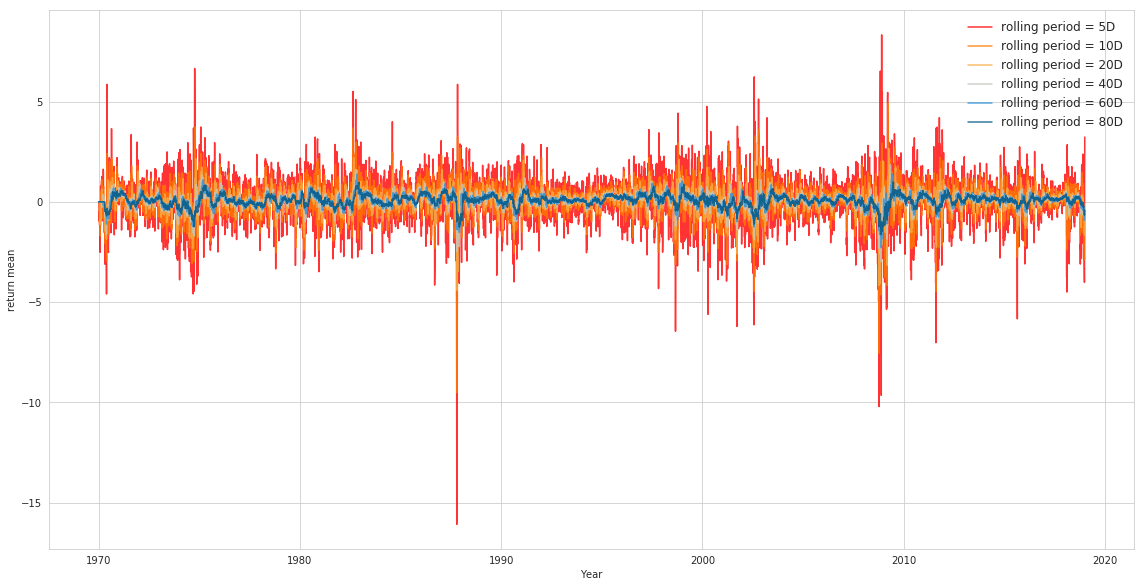

In [32]:
# too many windows, only display six
fig = plt.figure(figsize=(16, 32))
index = 1
for moment in ['mean']: 
    ax = fig.add_subplot(4, 1, index)
    cint = 0
    for term in terms.keys():
        ax.plot(df[moment+"_"+term], color=cmap[cint], label='rolling period = '+term, alpha=.8)
        cint += 1
        if cint==6:
            break
    plt.xlabel('Year')
    plt.ylabel('return '+moment)
    plt.legend(frameon=False, prop={'size': 12})
    plt.tight_layout()
    index += 1

Return distribution.

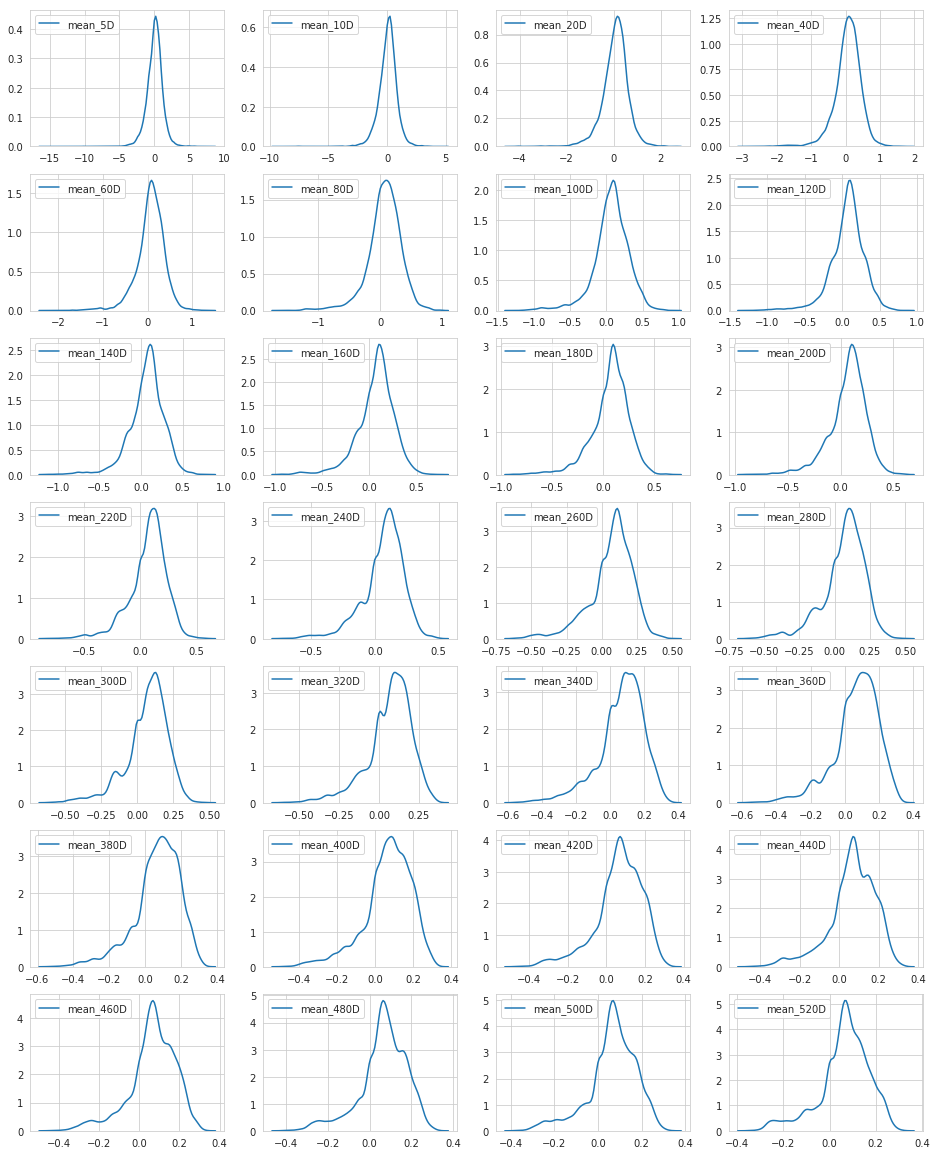

In [33]:
num_window = len(terms)
sns.set_style('whitegrid')
fig = plt.figure(figsize=(16, num_window*3))

index = 1
for term in terms:
    for i in ['mean_']:
        plt.subplot(num_window, 4, index)
        sns.kdeplot(df[i+term])
        index += 1

### Part 5: Fitting 

Empirical distribution for window size 20D.

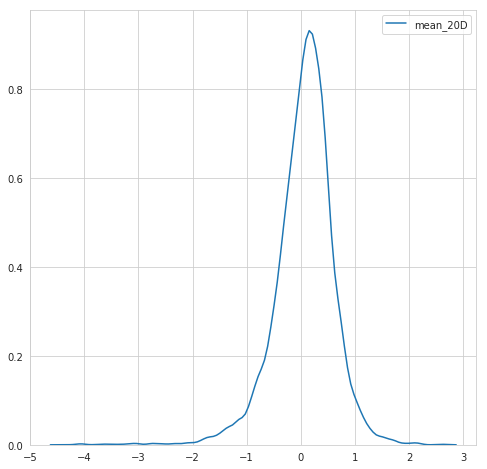

In [34]:
fig = plt.figure(figsize=(8, 8))
sns.kdeplot(df["mean_20D"])

In [35]:
# pick sample data points for fitting
std = df["mean_20D"].std()
x = [round(elem, 4) for elem in np.arange(-2.5*std, 3*std, 0.5*std)]
test = pd.DataFrame(x, columns=['r'])

# calculate the kde density of the data points
kde = KernelDensity(bandwidth=0.01)
kde.fit(df[['mean_20D']])
test['f_r'] = [round(elem, 4) for elem in np.exp(kde.score_samples(test[['r']]))]
test

,r,f_r
0,-1.3759,0.0341
1,-1.1007,0.0582
2,-0.8255,0.1174
3,-0.5504,0.2473
4,-0.2752,0.5542
5,0.0000,0.8955
6,0.2752,0.9216
7,0.5504,0.4802
8,0.8255,0.2011
9,1.1007,0.0719


In [36]:
result = pd.DataFrame(columns=['method', 'a', 'b', 'c', 'sse'])

In [37]:
linear_search_range = np.arange(-5, 5.1, 0.1)
for a in linear_search_range:
    for b in linear_search_range:
        
        test['f_r_calc'] = [round(calc_density(x=elem, r=0, T=20/260, sigma=sigma_func_linear(elem, a, b), delta_x=0.01), 4) for elem in test['r']]
        test['sse'] = round((test['f_r_calc'] - test['f_r'])**2, 4)
        result = result.append({'method': 'linear',
                                'a': round(a, 4),
                                'b': round(b, 4),
                                'c': 0,
                                'sse': round(np.sum(test['sse']), 4)}, ignore_index=True)

In [38]:
result.sort_values(by=['sse']).head()

,method,a,b,c,sse
7537,linear,2.4,1.3,0,1.4819
7334,linear,2.2,1.2,0,1.5269
7740,linear,2.6,1.4,0,1.5733
7131,linear,2.0,1.1,0,1.7048
7638,linear,2.5,1.3,0,1.7320


In [39]:
quad_search_range = np.arange(-5, 5.1, 0.5)
for a in quad_search_range:
    for b in quad_search_range:
        for c in quad_search_range:

            test['f_r_calc'] = [round(calc_density(x=elem, r=0, T=20/260, sigma=sigma_func_quad(elem, a, b, c), delta_x=0.01), 4) for elem in test['r']]
            test['sse'] = round((test['f_r_calc'] - test['f_r'])**2, 4)
            result = result.append({'method': 'quad',
                                    'a': round(a, 4),
                                    'b': round(b, 4),
                                    'c': round(c, 4),
                                    'sse': round(np.sum(test['sse']), 4)}, ignore_index=True)

In [40]:
result.sort_values(by=['sse']).head()

,method,a,b,c,sse
19159,quad,5.0,-2.0,1,1.0323
19138,quad,5.0,-2.5,1,1.0561
19180,quad,5.0,-1.5,1,1.0829
18718,quad,4.5,-2.0,1,1.1099
19097,quad,5.0,-3.5,1.5,1.1407


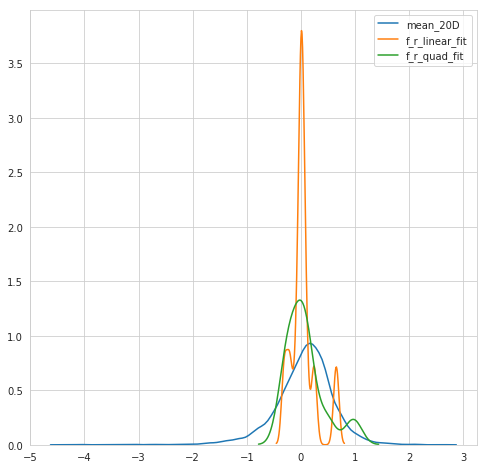

In [46]:
test['f_r_linear_fit'] = [round(calc_density(x=elem, r=0, T=20/260, sigma=sigma_func_linear(elem, 2.4, 1.3), delta_x=0.01), 4) for elem in test['r']]
test['f_r_quad_fit'] = [round(calc_density(x=elem, r=0, T=20/260, sigma=sigma_func_quad(elem, 5.0, -2.0, 1), delta_x=0.01), 4) for elem in test['r']]

fig = plt.figure(figsize=(8, 8))
sns.kdeplot(df["mean_20D"])
sns.kdeplot(test["f_r_linear_fit"])
sns.kdeplot(test["f_r_quad_fit"])

Text(0, 0.5, 'volatility')

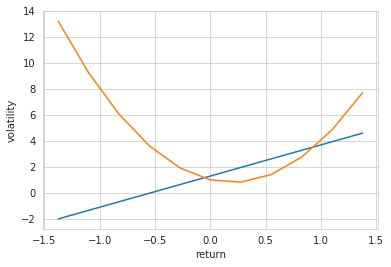

In [47]:
vol_curve = pd.DataFrame(x, columns=['r'])
vol_curve['vol_linear_fit'] = [sigma_func_linear(elem, 2.4, 1.3) for elem in vol_curve['r']]
vol_curve['vol_quad_fit'] = [sigma_func_quad(elem, 5.0, -2.0, 1) for elem in vol_curve['r']]

plt.plot(vol_curve['r'], vol_curve['vol_linear_fit'])
plt.plot(vol_curve['r'], vol_curve['vol_quad_fit'])
plt.xlabel('return')
plt.ylabel('volatility')
